## Setup environment

In [1]:

from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
import json
from datetime import datetime
from data_preparation2 import DataHandling 
from UNet_model import create_unet
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, Spacingd,
    SpatialPadd, ScaleIntensityd, CenterSpatialCropd
)

import math

In [5]:
data_dir = '/homes/zshahpouri/DLP/ASC-PET-001'
directory = '/homes/zshahpouri/DLP/Practic/LOGTEST'
output_dir = '/homes/zshahpouri/DLP/Practic/OUT'


train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"image": img, "target": tar} for img, tar in zip(train_images, target_images)]


# Calculate split sizes
total_size = len(data_dicts)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
# The test set gets the remaining data points
test_size = total_size - train_size - val_size

# Split the dataset
train_files = data_dicts[:train_size]
val_files = data_dicts[train_size:(train_size + val_size)]
test_files = data_dicts[(train_size + val_size):]

roi_size = [168, 168, 320]

train_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),
        SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant'),  # Pad to ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
        ])

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),
        SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant'),  # Pad to ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
        ])

test_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        # Spacingd(keys=["image", "target"], pixdim=(4.07, 4.07, 3.00)),
        SpatialPadd(keys=["image", "target"], spatial_size=(200, 200, 350), mode='constant'),  # Pad to ensure minimum size
        CenterSpatialCropd(keys=["image", "target"], roi_size=roi_size),  # Crop to ensure exact size
        ])


# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
# train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4)

test_ds = CacheDataset(data=test_files, transform=test_transforms, cache_rate=1.0, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=4)



Loading dataset:   0%|          | 0/36 [00:00<?, ?it/s]

Loading dataset: 100%|██████████| 20/20 [00:09<00:00,  2.22it/s]


## Set dataset path

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

log_filename = 'log_2_14_9_7.txt'

log_filepath = directory + '/'+ log_filename

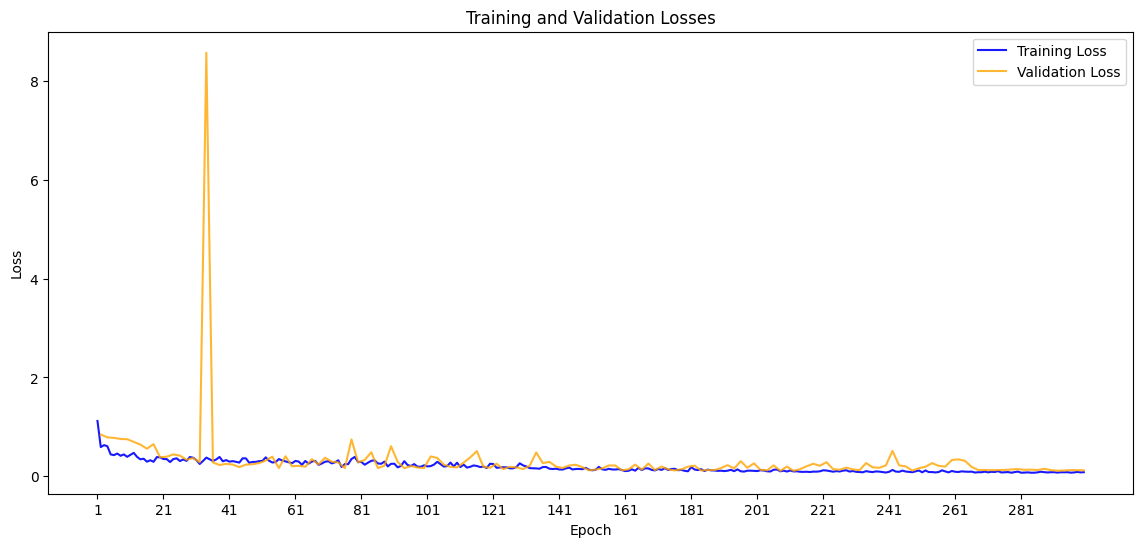

In [7]:

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses


train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2

# Plotting

plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 20))  # Adjust the x-axis ticks if needed
plt.show()


In [8]:
from utils import find_last_best_model

bestmodel_filename, best_metric, best_epoch = find_last_best_model(log_filepath)
print(f"Last Best Model Saved as: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Last Best Model Saved as: model_2_14_13_46.pth, Best Metric: 0.1058, Epoch: 208


In [9]:
log_filepath = directory + '/'+ log_filename
model_filename_to_find = bestmodel_filename
# model_filename_to_find = 'model_2_5_12_53.pth'

In [10]:
model = create_unet().to(device)
model.channels
model.strides
model.num_res_units
model.act



/homes/zshahpouri/DLP/.venv/lib/python3.11/site-packages/monai/networks/nets/unet.py:133: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


(torch.nn.modules.activation.ReLU6, {'inplace': True})

In [ ]:
def read_config(config_path):
    with open(config_path, 'r') as config_file:
        return json.load(config_file)
    
config_path = "/homes/zshahpouri/DL_PET/training_params.json"
config = read_config(config_path)
config['max_epochs']

10

In [ ]:


model_path = os.path.join(directory, model_filename_to_find)
    
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
print("Checkpoint keys:", checkpoint.keys())

# If your model state dict is directly at the root
state_dict_keys = checkpoint.keys()

# If your model state dict is nested under a key, e.g., 'state_dict'
# state_dict_keys = checkpoint['state_dict'].keys()

model_keys = model.state_dict().keys()

print("Keys in checkpoint not in model:", [key for key in state_dict_keys if key not in model_keys])
print("Keys in model not in checkpoint:", [key for key in model_keys if key not in state_dict_keys])

# Check for size mismatches
for key in model_keys:
    if key in checkpoint and checkpoint[key].size() != model.state_dict()[key].size():
        print(f"Size mismatch for {key}: checkpoint {checkpoint[key].size()}, model {model.state_dict()[key].size()}")


Checkpoint keys: odict_keys(['model.0.conv.unit0.conv.weight', 'model.0.conv.unit0.conv.bias', 'model.0.conv.unit0.adn.N.weight', 'model.0.conv.unit0.adn.N.bias', 'model.0.conv.unit0.adn.N.running_mean', 'model.0.conv.unit0.adn.N.running_var', 'model.0.conv.unit0.adn.N.num_batches_tracked', 'model.0.conv.unit1.conv.weight', 'model.0.conv.unit1.conv.bias', 'model.0.conv.unit1.adn.N.weight', 'model.0.conv.unit1.adn.N.bias', 'model.0.conv.unit1.adn.N.running_mean', 'model.0.conv.unit1.adn.N.running_var', 'model.0.conv.unit1.adn.N.num_batches_tracked', 'model.0.residual.weight', 'model.0.residual.bias', 'model.1.submodule.0.conv.unit0.conv.weight', 'model.1.submodule.0.conv.unit0.conv.bias', 'model.1.submodule.0.conv.unit0.adn.N.weight', 'model.1.submodule.0.conv.unit0.adn.N.bias', 'model.1.submodule.0.conv.unit0.adn.N.running_mean', 'model.1.submodule.0.conv.unit0.adn.N.running_var', 'model.1.submodule.0.conv.unit0.adn.N.num_batches_tracked', 'model.1.submodule.0.conv.unit1.conv.weight', 

In [ ]:
def load_model(directory, model_filename):
    model_path = os.path.join(directory, model_filename)
    if os.path.exists(model_path):
        
        # Load the model onto the CPU
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
        print(f"Model file {model_filename} is loaded successfully.")
    else:
        print(f"Model file {model_filename} not found.")

def find_model_info(log_filepath, model_filename):
    metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if model_filename in line:
                parts = line.split(',')
                metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
                return model_filename, metric, epoch
    return model_filename, metric, epoch





load_model(directory, model_filename_to_find)

bestmodel_filename, metric, epoch = find_model_info(log_filepath, model_filename_to_find)
print(f"Model has been selected: {bestmodel_filename}, Metric: {metric}, Epoch: {epoch}")

Model file model_2_7_16_28.pth is loaded successfully.
Model has been selected: model_2_7_16_28.pth, Metric: 0.0623, Epoch: 476


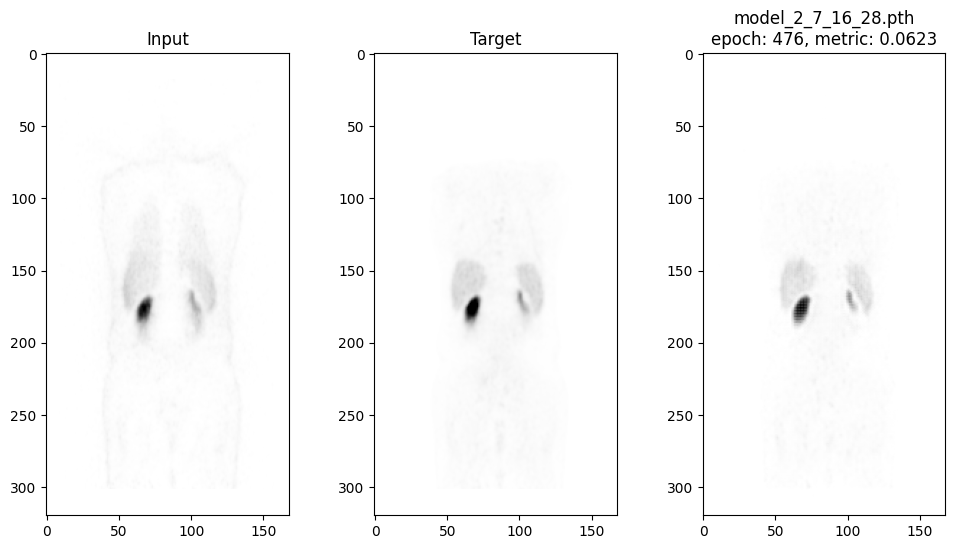

In [ ]:
def visualize_results_whole(data, model, n, title):
    model.eval()
    with torch.no_grad():
        outputs = model(data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(data["image"][0, 0, :, n, :])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Target")
    target_slice = np.rot90(data["target"][0, 0, :, n, :])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(outputs.detach().cpu()[0, 0, :, n, :])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, data in enumerate(test_loader):
        n = 100
        visualize_results_whole(data, model, n, f"{model_filename_to_find}\nepoch: {epoch}, metric: {metric}")
        if i == 0:
            break


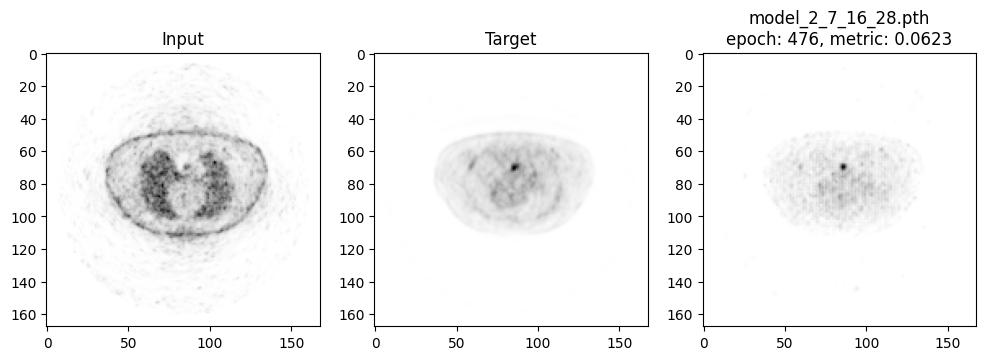

In [ ]:
# Saggital 
def visualize_results_whole(data, model, n, title):
    model.eval()
    with torch.no_grad():
        outputs = model(data["image"].to(device))

    plt.figure("check", (12, 6))

    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    input_slice = np.rot90(data["image"][0, 0, :, :, n])
    plt.imshow(input_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Target")
    target_slice = np.rot90(data["target"][0, 0, :, :, n])
    plt.imshow(target_slice, cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = np.rot90(outputs.detach().cpu()[0, 0, :, :, n])
    plt.imshow(output_slice, cmap="gist_yarg")
    
    plt.show()

# Usage
with torch.no_grad():
    for i, data in enumerate(test_loader):
        n = 200
        visualize_results_whole(data, model, n, f"{model_filename_to_find}\nepoch: {epoch}, metric: {metric}")
        if i == 0:
            break


100%|██████████| 14/14 [00:13<00:00,  1.07it/s]


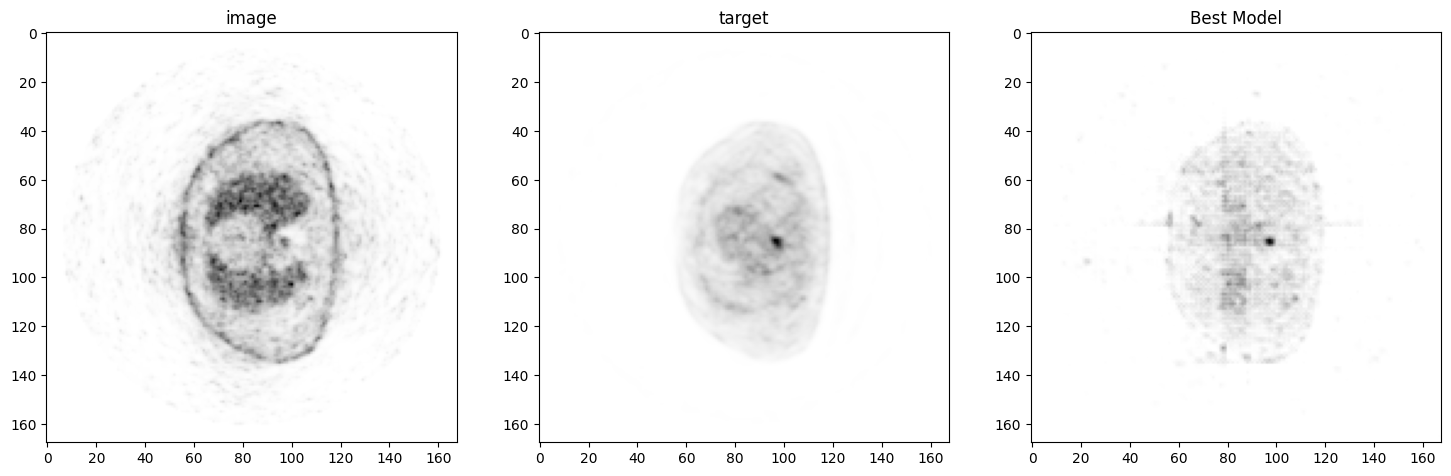

In [ ]:
# Loadinf with sliding_window_inference
 
from monai.inferers import sliding_window_inference


        
def visualize_results(data, model, n, title):

    outputs = sliding_window_inference(data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.30) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(data["image"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(data["target"][0, 0, :, :, n], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gist_yarg") # "gist_yarg")
    plt.show()


    # Load the best model state for visualization

model.eval()
roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, data in enumerate(test_loader):

        n = 200
        visualize_results(data, model, n, f"Best Model")
        if i == 0:
            break




------------------
# Quantification Evaluation

In [ ]:
import numpy as np
import torch
from skimage.metrics import structural_similarity as ssim
from math import log10, sqrt

def mean_error(predicted, reference):
    return np.mean(predicted - reference)

def mean_absolute_error(predicted, reference):
    return np.mean(np.abs(predicted - reference))

def relative_error(predicted, reference, epsilon=0.3):
    return np.mean((predicted - reference) / (reference + epsilon)) * 100

def absolute_relative_error(predicted, reference, epsilon=0.3):
    return np.mean(np.abs(predicted - reference) / (reference + epsilon)) * 100

def rmse(predicted, reference):
    return sqrt(np.mean((predicted - reference) ** 2))

def psnr(predicted, reference, peak):
    mse = np.mean((predicted - reference) ** 2)
    return 20 * log10(peak / sqrt(mse))

def calculate_ssim(predicted, reference):
    return ssim(predicted, reference, data_range=reference.max() - reference.min())


In [ ]:
import numpy as np

def evaluate_metrics(data_loader, model, device):
    sum_mean_error = sum_mae = sum_re = sum_are = sum_rmse = sum_psnr = sum_ssim = num_patients = 0

    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data["image"].to(device), data["target"].to(device)
            outputs = model(inputs)

            outputs_np = np.squeeze(outputs.cpu().numpy() * 5, axis=1)
            targets_np = np.squeeze(targets.cpu().numpy() * 5, axis=1)

            for output, target in zip(outputs_np, targets_np):
                peak = np.max([output.max(), target.max()])
                sum_mean_error += mean_error(output, target)
                sum_mae += mean_absolute_error(output, target)
                sum_re += relative_error(output, target)
                sum_are += absolute_relative_error(output, target)
                sum_rmse += rmse(output, target)
                sum_psnr += psnr(output, target, peak)
                sum_ssim += calculate_ssim(output, target)
                num_patients += 1

    metrics = {
        "mean_ME": sum_mean_error / num_patients,
        "mean_MAE": sum_mae / num_patients,
        "mean_RE%": sum_re / num_patients,
        "mean_ARE%": sum_are / num_patients,
        "mean_RMSE": sum_rmse / num_patients,
        "mean_PSNR": sum_psnr / num_patients,
        "mean_SSIM": sum_ssim / num_patients
    }

    return metrics


val_metrics = evaluate_metrics(val_loader, model, device)
print("Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.2f}")

test_metrics = evaluate_metrics(test_loader, model, device)
print("\nTest Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.2f}")




Validation Metrics:
mean_ME: -0.02
mean_MAE: 0.23
mean_RE%: 5.95
mean_ARE%: 14.96
mean_RMSE: 1.21
mean_PSNR: 44.84
mean_SSIM: 0.99

Test Metrics:
mean_ME: -0.14
mean_MAE: 0.31
mean_RE%: 6.60
mean_ARE%: 18.79
mean_RMSE: 1.37
mean_PSNR: 43.61
mean_SSIM: 0.98


In [ ]:
def evaluate_metrics(data_loader, model, device):
    metrics = {
        "mean_error": [],
        "mae": [],
        "re": [],
        "are": [],
        "rmse": [],
        "psnr": [],
        "ssim": []
    }

    model.eval()
    with torch.no_grad():
        for data in data_loader:
            inputs, targets = data["image"].to(device), data["target"].to(device)
            outputs = model(inputs)

            outputs_np = np.squeeze(outputs.cpu().numpy() * 5, axis=1)
            targets_np = np.squeeze(targets.cpu().numpy() * 5, axis=1)

            for output, target in zip(outputs_np, targets_np):
                peak = np.max([output.max(), target.max()])
                metrics["mean_error"].append(mean_error(output, target))
                metrics["mae"].append(mean_absolute_error(output, target))
                metrics["re"].append(relative_error(output, target))
                metrics["are"].append(absolute_relative_error(output, target))
                metrics["rmse"].append(rmse(output, target))
                metrics["psnr"].append(psnr(output, target, peak))
                metrics["ssim"].append(calculate_ssim(output, target))

    # Calculate mean and standard deviation for each metric
    metric_means_sds = {
        metric: (np.mean(values), np.std(values)) for metric, values in metrics.items()
    }

    return metric_means_sds
val_metrics = evaluate_metrics(val_loader, model, device)
def print_metrics(metrics, title):
    print(f'\n',title)
    for metric, (mean, sd) in metrics.items():
        print(f"{metric}: {mean:.2f} ± {sd:.2f}")

val_metrics = evaluate_metrics(val_loader, model, device)
print_metrics(val_metrics, "Validation Metrics:")

test_metrics = evaluate_metrics(test_loader, model, device)
print_metrics(test_metrics, "Test Metrics:")



 Validation Metrics:
mean_error: -0.02 ± 0.08
mae: 0.23 ± 0.05
re: 5.95 ± 4.39
are: 14.96 ± 1.96
rmse: 1.21 ± 0.50
psnr: 44.84 ± 1.88
ssim: 0.99 ± 0.00

 Test Metrics:
mean_error: -0.14 ± 0.12
mae: 0.31 ± 0.07
re: 6.60 ± 3.81
are: 18.79 ± 4.04
rmse: 1.37 ± 0.57
psnr: 43.61 ± 2.45
ssim: 0.98 ± 0.01


-------------------------
# Exporting DL-PET output


In [ ]:
# import nibabel as nib
# import os
# import numpy as np
# import torch


# # Extract file names
# test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]


# import nibabel as nib
# import os
# import numpy as np
# import torch

# def save_nifti(data, filename, affine=np.eye(4)):
#     """Save the data as a NIfTI file."""
#     nifti_img = nib.Nifti1Image(data, affine)
#     nib.save(nifti_img, filename)

# def save_output(test_data, model, output_dir, file_names):
#     """Save model output for test data to NIfTI files."""
#     model.eval()
#     with torch.no_grad():
#         test_outputs = model(test_data["image"].to(device))

#     # Loop over each item in the batch and save outputs
#     for i in range(test_outputs.shape[0]):  # Adjust based on your model's output shape
#         output_data = test_outputs[i, 0, :, :, :].detach().cpu().numpy()  # Assuming single-channel output
#         output_file_path = os.path.join(output_dir, f"DL_{file_names[i]}.nii.gz")
#         save_nifti(output_data, output_file_path)

# # Assuming test_loader is correctly setup
# with torch.no_grad():
#     for i, test_data in enumerate(test_loader):
#         # Assuming test_name's order aligns with test_loader's batches
#         # Extract only the image filenames for the current batch
#         batch_file_names = [name[0] for name in test_name[i*len(test_data["image"]):(i+1)*len(test_data["image"])]]

#         # Save the output using the batch-specific filenames
#         save_output(test_data, model, output_dir, batch_file_names)
#         if i == 0:  # Adjust as needed
#             break



In [ ]:
# def save_nifti(data, filename, affine=np.eye(4)):
#     nifti_img = nib.Nifti1Image(data, affine)
#     nib.save(nifti_img, filename)

# def save_output_and_ground_truth(test_data, model, output_dir, file_names):
#     model.eval()
#     with torch.no_grad():
#         test_outputs = model(test_data["image"].to(device))

#     # Loop over each item in the batch
#     for i in range(len(test_data["image"])):

#         # Save ground truth
#         ground_truth_data = test_data["target"][i, 0, :, :, :].detach().cpu().numpy()
#         ground_truth_file_path = os.path.join(output_dir, f"{file_names[i]}")
#         save_nifti(ground_truth_data, ground_truth_file_path)


# with torch.no_grad():
#     for i, test_data in enumerate(test_loader):
#         # Extract filenames from test_files
#         file_names = [os.path.basename(file_info['image']) for file_info in test_name[i*len(test_data["image"]):(i+1)*len(test_data["image"])]]

#         # Save the model output and ground truth using the modified file names
#         save_output_and_ground_truth(test_data, model, output_dir, file_names)


--------------
# Exporting Output images with original hearders

In [ ]:
# Extract file names
test_name = [(os.path.splitext(os.path.basename(file_info['image']))[0], os.path.splitext(os.path.basename(file_info['target']))[0]) for file_info in test_files]



In [ ]:
import nibabel as nib

def get_nifti_header(file_path):
    nifti_img = nib.load(file_path)
    header_info = nifti_img.header
    return header_info
# Dictionary to hold header information of test files before transformations
test_headers_before = {}

for file_dict in test_files:
    image_path = file_dict["image"]
    target_path = file_dict["target"]
    image_header = get_nifti_header(image_path)
    target_header = get_nifti_header(target_path)
    # Extracting filename without extension for key
    file_key = os.path.splitext(os.path.basename(image_path))[0]
    test_headers_before[file_key] = {"image_header": image_header, "target_header": target_header}

In [ ]:
def save_nifti(data, filename, affine):
    """Save the data as a NIfTI file with the provided affine matrix."""
    nifti_img = nib.Nifti1Image(data, affine)
    nib.save(nifti_img, filename)

def save_output_with_affine(test_data, model, output_dir, file_names, affine_matrices):
    """Save model output for test data to NIfTI files, preserving affine matrices."""
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_data["image"].to(device))

    # Loop over each item in the batch and save outputs with the corresponding affine matrix
    for i in range(test_outputs.shape[0]):  # Adjust based on your model's output shape
        output_data = test_outputs[i, 0, :, :, :].detach().cpu().numpy()  # Assuming single-channel output
        output_file_path = os.path.join(output_dir, f"DL_{file_names[i]}.gz")
        affine = affine_matrices[file_names[i]]
        save_nifti(output_data, output_file_path, affine)


In [ ]:
# Modify the loop to include affine matrix while saving
with torch.no_grad():
    for i, test_data in enumerate(test_loader):
        # Assuming test_name's order aligns with test_loader's batches
        # Extract only the image filenames for the current batch
        batch_file_names = [name[0] for name in test_name[i*len(test_data["image"]):(i+1)*len(test_data["image"])]]

        # Extract affine matrices for the current batch
        batch_affine_matrices = {name: test_headers_before[name]["image_header"].get_best_affine() for name in batch_file_names}

        # Save the output using the batch-specific filenames and affine matrices
        save_output_with_affine(test_data, model, output_dir, batch_file_names, batch_affine_matrices)
        if i == 0:  # Adjust as needed
            break
